In [1]:
import sys
sys.path.append('/home/asagodi/Documents/UvA/Master/Projects/MES/LIF/FuncsTools')

In [2]:
'''
Trains a simple deep RNN on the MNIST dataset.
'''
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import itertools
import networkx as nx

from MESfunctions import *
from additkerastf import *

batch_size = 32
num_classes = 10
epochs = 2

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 1, 784)
x_test = x_test.reshape(10000, 1, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train = y_train.reshape(60000,10)
y_test = y_test.reshape(10000,10)

model = Sequential()
model.add(keras.layers.recurrent.SimpleRNN(100, input_dim=784, input_length=1, return_sequences=True))
# model.add(keras.layers.recurrent.SimpleRNN(32, return_sequences=True))
# model.add(keras.layers.recurrent.SimpleRNN(16, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform',
#                                  recurrent_initializer='orthogonal', bias_initializer='zeros',
#                                  kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None,
#                                  activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None,
#                                  bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
model.add(keras.layers.recurrent.SimpleRNN(10))

model.summary()

Using TensorFlow backend.


60000 train samples
10000 test samples


/home/asagodi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:44: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/asagodi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:44: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(100, return_sequences=True, input_shape=(1, 784))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1, 100)            88500     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10)                1110      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [3]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 23s - loss: 9.2899 - acc: 0.1718 - val_loss: 9.6983 - val_acc: 0.1772
Epoch 2/2
60000/60000 [==============================] - 21s - loss: 9.7756 - acc: 0.1751 - val_loss: 9.6983 - val_acc: 0.1772
Test loss: 9.6982580307
Test accuracy: 0.1772


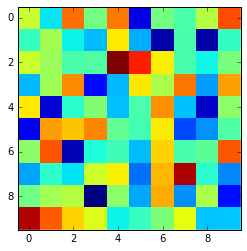

In [5]:
# plt.imshow(rec_weight_mat_2, interpolation='none', cmap=plt.cm.jet) 
# plt.show()

In [6]:
lp, lpnd, dp = find_pattern_by_weight(9, rec_weight_mat_2, 0.42, 3)

In [56]:
#get weights from input to layer 1
inp_weight_mat = get_weights_TF(model, 0)

#get weights from layer 1 to 2
proj_weight_mat = get_weights_TF(model, 3)

#get weights in layer 1
rec_weight_mat_1 = get_weights_TF(model, 1)  

#get weights in layer 2
rec_weight_mat_2 =  get_weights_TF(model, 4)

In [8]:
patt_len = 3
lp, lpnd, dp = find_pattern_by_weight(0, rec_weight_mat_1, 0.2142, patt_len)
# print(len(dp[patt_len]))
allnum = [item for sublist in dp[patt_len] for item in sublist]
print(len(allnum))


3


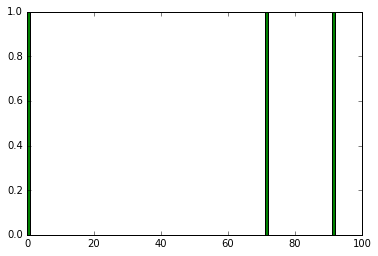

In [9]:
from collections import Counter

dictnums = Counter(allnum)
pos = np.arange(len(dictnums.keys()))
ax = plt.axes()
plt.bar(dictnums.keys(), dictnums.values(), 1, color='g')                 
plt.show()

In [10]:
relevantneurons = [ k for k in dictnums.keys() if dictnums[k] > 30 ]
print(relevantneurons)

[]


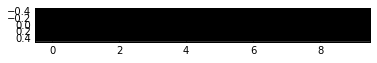

In [11]:
outp = colimit_of_pattern(relevantneurons, proj_weight_mat, activation=0.25)
plt.imshow(outp.reshape(1,10), interpolation='none', cmap=plt.cm.gray) 
plt.show()

In [12]:
#check whether colimit is strongly connected
lp, lpnd, dp = find_pattern_by_weight(1, rec_weight_mat_2, 0.42, 3)

In [13]:
print(dp)
#there is at least one pattern that is like the colimit
#but pattern for increased activation limit colimit is not in possible colimits

{}


In [45]:
import networkx as nx
rec_weight_mat_2_round = np.around(rec_weight_mat_2, decimals = 3)
G=nx.DiGraph(rec_weight_mat_2_round)
nx.strongly_connected_components(G)

<generator object strongly_connected_components at 0x7fb16c1275a0>

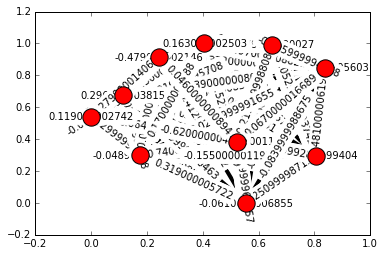

In [46]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos, edgelist = G.edges(), arrows=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()

In [47]:
print(rec_weight_mat_2_round)

[[ 0.163      -0.171       0.447       0.022       0.426      -0.54400003
   0.025      -0.048       0.12800001  0.49700001]
 [-0.09        0.11       -0.155      -0.236       0.257      -0.25099999
  -0.61299998 -0.053      -0.62       -0.093     ]
 [ 0.17        0.089      -0.049      -0.035       0.74000001  0.56800002
   0.25       -0.05       -0.153       0.029     ]
 [-0.23800001  0.09        0.40000001 -0.479      -0.237       0.26499999
   0.115       0.43700001 -0.27900001  0.37200001]
 [ 0.257      -0.56400001 -0.108       0.046      -0.228      -0.05
   0.39399999 -0.22       -0.583       0.067     ]
 [-0.528       0.37099999  0.31900001  0.41299999 -0.009      -0.061
   0.25999999 -0.39300001 -0.29100001 -0.038     ]
 [ 0.063       0.484      -0.60299999 -0.12800001 -0.067      -0.23100001
   0.296      -0.051      -0.018       0.48300001]
 [-0.26499999 -0.101      -0.178       0.175       0.25099999 -0.33899999
   0.33700001  0.67900002 -0.106      -0.30599999]
 [ 0.017   

In [17]:
nx.strongly_connected_components(G)

<generator object strongly_connected_components at 0x7fb1830ed4b0>

In [18]:
[len(c) for c in sorted(nx.strongly_connected_components(G),
                        key=len, reverse=True)]

[10]

In [19]:
[print(c) for c in sorted(nx.strongly_connected_components(G),
                        key=len, reverse=True)]

set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


[None]

In [48]:
G=nx.DiGraph(rec_weight_mat_2 >0.39)
nx.strongly_connected_components(G)
[print(c) for c in sorted(nx.strongly_connected_components(G),
                        key=len, reverse=True)]

set([0, 2, 3, 4, 5, 6, 9])
set([1])
set([7])
set([8])


[None, None, None, None]

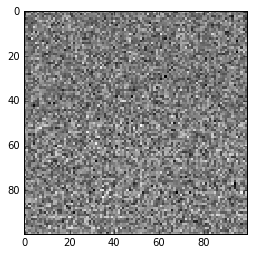

In [74]:
#make synchronisation plot
syncplot = x_test.reshape(10000, 784).dot(inp_weight_mat).mean(axis=1)
syncplot = syncplot.reshape(100,100)
plt.imshow(syncplot, interpolation='none', cmap=plt.cm.gray) 
plt.show()

In [72]:
syncplot.shape

(100, 100)